In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from matplotlib import cm
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

###  Useful functions definitions

In [26]:
# Useful function definitions, explained throughout the text below

# Poisson regression canonical inverse link function
#invLinkFun = lambda X, w: np.exp(np.dot(X, w))

# Poisson regression, rectified inverse link function
def invLinkFun(X, w):
    z = np.dot(X, w)
    mu = np.zeros(z.shape)
    mu[z<0] = np.exp(z[z<0])
    mu[z>=0] = z[z>=0] + 1
    return mu
# Poisson regression, log-likelihood
logLikFun = lambda X, w, y: np.sum(y*np.log(invLinkFun(X, w))-invLinkFun(X, w))
# Poisson regression, negative log-likelihood
negLogLikFun = lambda X, w, y: np.sum(invLinkFun(X, w) - y*np.log(invLinkFun(X, w)))
# Poisson regression, gradient of the negative log-likelihood
def negLogLikDerFun(X, w, y):
    z = np.dot(X, w)
    der = np.dot(np.exp(z[z<0])-y[z<0], X[z<0, :])
    der += np.dot(1-y[z>=0]/(z[z>=0]+1), X[z>=0, :])
    return der

# Get n grayscale colors
def getGrayColors(n):
    colors = [];
    for i in range(1, n+1):
        colors.append(i/(n+1.)*np.ones(3))
    return colors

### Example case 

Suppose we have observed spike responses $y_i$ to some one-dimensional stimulus $x_i$, $i \in 1,\dots, N$. Furthermore, suppose that the cell exhibited some thresholding mechanism: hardly any spikes were observed for stimulus values below a certain threshold, whereas the response grew roughly linearly above the threshold. We would thus like to describe the cell's stimulus response mapping using a simple model, and one alternative is a soft-rectifying function:
\begin{equation}
 \hat{y_i} = f(z_i) = 
 \begin{cases}
  \exp(z_i),& \text{if  } z_i \leq 0\\
  z_i + 1,& \text{if  } z_i > 0\\
 \end{cases}
\end{equation}
where $\hat{y_i}$ is the predicted output, $z_i=w_0+w_1x_i$, $w_0$ the threshold, and $w_1$ the slope. However, it is often simpler to work with vector notations, and in such cases, we define $z_i$ as a dot product between a parameter vector and a stimulus vector $\mathbf{w}^T\mathbf{x}_i$, where $\mathbf{w}=[w_0,\; w_1]$ and $\mathbf{x}_i=[1; x_i]$.

In [3]:
# Parameters
n = 200;
wTrue = [-1, 0.5]

# Generate example data
x = np.random.rand(n)*30 - 15
x = np.sort(x)
X = np.vstack([-np.ones(n), x]).T
mu = invLinkFun(X, wTrue)
y = np.random.poisson(mu)

# Callback plotting function for interactive plots
def plot_fun(x, y, w0, w1):
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, 'k.', label='data')
    wTmp = np.array([w0, w1])
    muTmp = invLinkFun(X, wTmp)
    ax.plot(x, muTmp, '-', color=0.5*np.ones(3))
    ax.set_ylabel('Spike count')
    ax.set_xlabel('x')
    ax.set_xticks([-10, 0, 10]);
    ax.set_ylim([-1, 11]);

interact(plot_fun, x=fixed(x), y=fixed(y), w0=(-5., 5.), w1=(-5., 5.));

interactive(children=(FloatSlider(value=0.0, description='w0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

### Objective functions

A manual search for good parameter values can be quite tricky and cumbersome, especially if there are more than just two model parameters. An automatic way would be a lot simpler, but for that we need some measure of how "good" a specific selection of model parameters are. One natural way of quantifying the "goodness" of parameters is through an objective function which scores each parameter combination. It might seen tricky to come up with such a function, but one common approach is to define it to be a likelihood function. The idea being that the likelihood function tells you how likely you are to observe the current data given some model parameters. For example, if we assume that the observed spike counts come from a Poisson distribution whose mean is given by our soft-rectifying function, then the probability $p$ of observing a specific data point ($x_i, y_i$) is given by:
\begin{equation}
 p(x_i, y_i|w_0, w_1) = \frac{f(z_i)^{y_i} \exp(-f(z_i))}{y_i!}.
\end{equation}
The likelihood function $l$ is then defined as the probability of observing all data points, where independence is essentially always assumed to simplify the expression into a product: 
\begin{equation}
 l(w_0, w_1) = \prod_i^N \frac{f(z_i)^{y_i} \exp(-f(z_i))}{y_i!}.
\end{equation}
The likelihood function is, however, often cumbersome to work with, and people tend to use the log of the likelihood function instead. Logarithms turns products into sums, and the log-likelihood function $ll$ thus has the form:
\begin{equation}
 ll(w_0, w_1) = \sum_i^N y_i\log(f(z_i)) -f(z_i) -\log(y_i!).
\end{equation}
Finally, we note that the last term can be ignored (it does not depend on our model parameters), whereupon we are left with:
\begin{equation}
 ll(w_0, w_1) = \sum_i^N y_i\log(f(z_i)) -f(z_i).
\end{equation}

Equipped with a function that quantifies the "goodness" of parameter choices, we can now select parameter values that maximizes the log-likelihood function.

##### Exampel 1, find w0 give w1

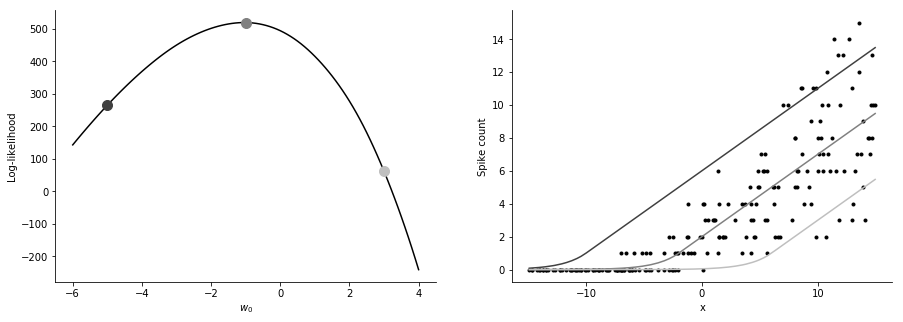

In [4]:
# Example parameters
w0Ex = np.array([wTrue[0]-4, wTrue[0], wTrue[0]+4])
w0Vals = np.linspace(wTrue[0]-5, wTrue[0]+5, 101)

# Log-likelihood function
ll = []
for w0 in w0Vals:
    wTmp = np.array([w0, wTrue[1]])
    ll.append(logLikFun(X, wTmp, y))

# Log-likelihood values for our example parameters
llEx = []
for w0 in w0Ex:
    wTmp = np.array([w0, wTrue[1]])
    llEx.append(logLikFun(X, wTmp, y))

# Plotting
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(15, 5))
# Log-likelihood
ax = fig.add_subplot(1, 2, 1)
ax.plot(w0Vals, ll, 'k-')
for i in range(w0Ex.size):
    ax.plot(w0Ex[i], llEx[i], 'o', ms=10, color=grayColors[i])
ax.set_xlabel('$w_0$')
ax.set_ylabel('Log-likelihood')
# Data and example response function mappings
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y, 'k.', label='data')
for i in range(w0Ex.size):
    wTmp = np.array([w0Ex[i], wTrue[1]])
    pTmp = invLinkFun(X, wTmp)
    ax.plot(x, pTmp, '-', color=grayColors[i])
ax.set_ylabel('Spike count')
ax.set_xlabel('x')
ax.set_xticks([-10, 0, 10]);

##### Example 2, find both w0 and w1

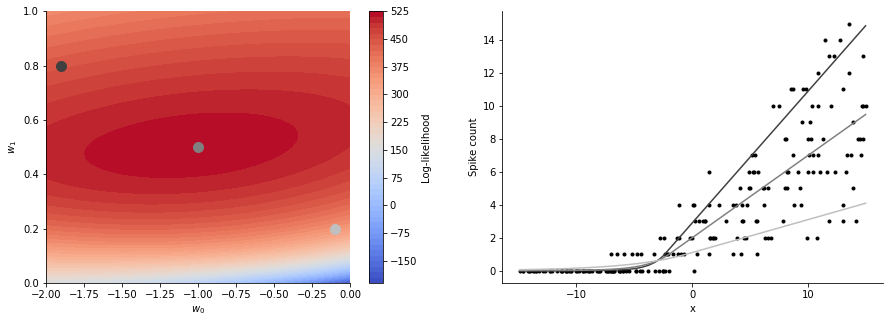

In [166]:
# Example parameters
wEx = np.array([[wTrue[0]-0.9, wTrue[0], wTrue[0]+0.9], [wTrue[1]+0.3, wTrue[1], wTrue[1]-0.3]])

# Get w0 and w1 combinations over a grid
nGrid = 51
W0, W1 = np.meshgrid(np.linspace(wTrue[0]-1, wTrue[0]+1, nGrid), np.linspace(wTrue[1]-0.5, wTrue[1]+0.5, nGrid))

# Get the log-likelihood for each parameter combination
llVals = np.zeros([nGrid, nGrid])
for i in range(nGrid):
    for j in range(nGrid):
        wTmp = np.array([W0[i, j], W1[i, j]])
        llVals[i, j] = logLikFun(X, wTmp, y)

# Plotting
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(15, 5))
# Log-lieklihood and example parameters
ax = plt.subplot(1, 2, 1)
contourHandle = ax.contourf(W0, W1, llVals, 50, cmap=cm.coolwarm)
for i in range(wEx.shape[1]):
    ax.plot(wEx[0, i], wEx[1, i], 'o', ms=10, color=grayColors[i])
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
cBarHandle = plt.colorbar(contourHandle)
cBarHandle.set_label('Log-likelihood')
# Data and example response function mappings
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y, 'k.', label='data')
for i in range(wEx.shape[1]):
    wTmp = wEx[:, i]
    pTmp = invLinkFun(X, wTmp)
    ax.plot(x, pTmp, '-', color=grayColors[i])
ax.set_ylabel('Spike count')
ax.set_xlabel('x')
ax.set_xticks([-10, 0, 10]);

### Optimization

At first sight, it might look like the objective function only slightly simplifies our problem of finding good parameter values: finding the maxima is easy when you see the objective function, but visualizing the function for more than three parameters is extremely difficult. Luckily, however, there is a whole optimization field devoted to finding the maxima or minima of functions using methods that don't require you to visualize the objective function. Roughly, these methods can be divided into first and second order methods, which will be introduced next. However, before continuing, we will modify our objective functions once more by multiplying it with -1. This is just to turn the maximization problem into a minimization problem, which is usually the default notation. The means that finding the best parameters values now corresponds to minimizing the negative log-likelihood $nll$: 

\begin{equation}
 nll(w_0, w_1) = \sum_i^N f(z_i) - y_i\log(f(z_i)).
\end{equation}

### Gradient

Most commonly used optimization methods utilize gradients. The gradient of a function is by definition a vector consisting of the partial derivatives with respect to each parameter. For our example from above, the gradient thus becomes:
\begin{equation}
 \nabla nll = \frac{\partial nll}{\partial \mathbf{w}} = \left[ \frac{\partial nll}{\partial w_0}, \frac{\partial nll}{\partial w_1} \right], 
\end{equation}
where $\nabla$ denotes the linear nabla operator. The fact that $\nabla$ is linear means that we can obtain the gradient of the negative log-likelihood function by just summing up the gradients of each term in the sum:
\begin{align}
 \nabla nll &= \sum_i^N \frac{\partial f(z_i) - y_i\log(f(z_i))}{\partial \mathbf{w}}, \\
 \frac{\partial f(z_i) - y_i\log(f(z_i))}{\partial \mathbf{w}} &= 
 \begin{cases}
  (\exp(z_i) - y_i)\mathbf{x}_i,& \text{if  } z_i \leq 0\\
  \left( 1-\frac{y_i}{z_i+1} \right) \mathbf{x}_i,& \text{if  } z_i > 0\\
 \end{cases}.
\end{align}
We can thus compute the gradient for any parameter values of our choice, but the real benefit of this possibility only becomes apparent when considering what the gradient really denotes. The partial derivative of any parameter tells us how quickly the function increases when that parameter is changed slightly, and consequently the gradient, which is the vector containing all partial derivatives, indicates in which direction in parameter space that the function value increases the most.

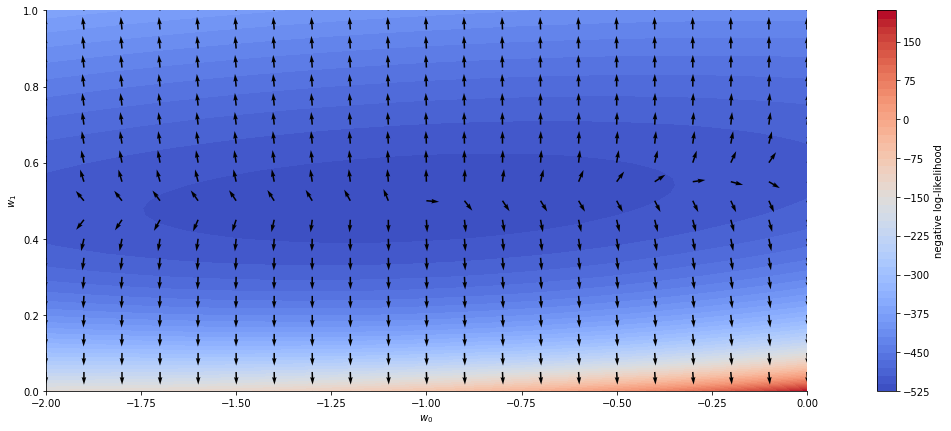

In [158]:
# Use lower resolution for gradient evaluations
nGrid = 21
W0q, W1q = np.meshgrid(np.linspace(wTrue[0]-1, wTrue[0]+1, nGrid), np.linspace(wTrue[1]-0.5, wTrue[1]+0.5, nGrid))

# Get the gradient for each combination
nllVals = np.zeros([nGrid, nGrid])
W0der = np.zeros([nGrid, nGrid])
W1der = np.zeros([nGrid, nGrid])
for i in range(nGrid):
    for j in range(nGrid):
        wTmp = np.array([W0q[i, j], W1q[i, j]])
        derTmp =  negLogLikDerFun(X, wTmp, y)
        W0der[i, j] = derTmp[0]
        W1der[i, j] = derTmp[1]

# Normalize to unit length
W0derNorm = W0der / np.sqrt(W0der**2. + W1der**2.)
W1derNorm = W1der / np.sqrt(W0der**2. + W1der**2.)
        
# Plotting
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(25, 7))
ax = plt.subplot(1, 1, 1)
ax.set_aspect('equal')
# Negative log-likelihood
contourHandle = ax.contourf(W0, W1, -llVals, 50, cmap=cm.coolwarm)
# Gradient
ax.quiver(W0q, W1q, W0derNorm, W1derNorm, angles='xy', scale_units='xy', scale=30, width=2e-3)
# Axes settings
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
cBarHandle = plt.colorbar(contourHandle)
cBarHandle.set_label('negative log-likelihood')

### Gradient descent

A stupidly simple idea for finding the minima of the negative log-likelihood function would then be to start from some parameters $\mathbf{w}_\mathrm{init}$ and then just iteratively move in the opposite direction to the gradient. That is, we evaluate the gradient for our current parameter guess and then we update our guess by subtracting the gradient times a constant $\eta$. More specifically, at each step $k$ of our iterative algorithm, we update our parameters as:
\begin{equation}
 \mathbf{w}_{k+1} = \mathbf{w}_k - \eta \nabla nll(\mathbf{w}_k).
\end{equation}
For sufficiently small $\eta$, this will guarantee that we backtrack along the gradients all the way to the minima of the negative log-likelihood function, as illustrated below.

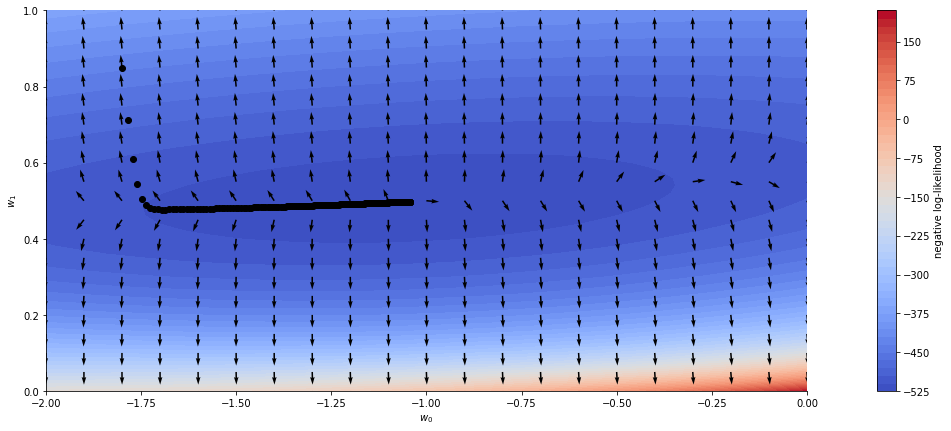

In [170]:
# Gradient descent parameters
wInit = np.array([-1.8, 0.85])
eta = 4e-4
        
# Plotting
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(25, 7))
ax = plt.subplot(1, 1, 1)
ax.set_aspect('equal')
# Negative log-likelihood
contourHandle = ax.contourf(W0, W1, -llVals, 50, cmap=cm.coolwarm)
# Gradient
ax.quiver(W0q, W1q, W0derNorm, W1derNorm, angles='xy', scale_units='xy', scale=30, width=2e-3)
# Parameters
ax.plot(wInit[0], wInit[1], 'ko')
# Gradient descent loop
for i in range(300):
    wInit -= eta*negLogLikDerFun(X, wInit, y)
    ax.plot(wInit[0], wInit[1], 'ko')
# Axes settings
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
cBarHandle = plt.colorbar(contourHandle)
cBarHandle.set_label('negative log-likelihood')